# Evaluating Answers
                

In [2]:
from commonfunctions import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

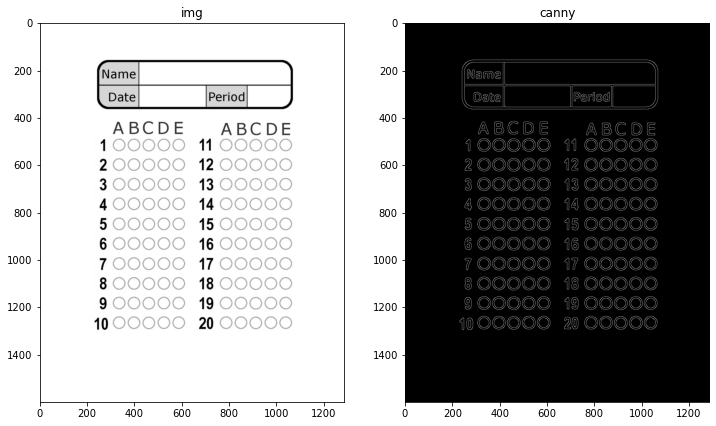

x centers [ 784  333  333  784  784  973  973  973  522 1036  458  333  522  333
  973  333  784 1036  585  458  522 1036  909  973  784  909 1036  396
  522  585  522  333  333  973  333  909  847  458 1036  847  847  585
  784  784  847  909  847  584  973  522  973  847  847  522  847  585
  522  396  522  458  396  522  333  396  458  396  973  909  458  333
  784  973  847  396  396  396  585  847  784  784 1036  396  847  909
  909  396  847  522  458  910 1036  396  396 1036  396  396 1036  458
  585  522]
y centers [1015 1015  597  680  597 1265 1182  763  763  680  681  680 1099 1099
  848  763  763  763  763 1016 1182 1099  598  514 1099 1016 1015 1015
  930  680  514 1182  514 1099  930  681  680  598  597  930 1015 1015
  514  930 1182 1100 1099 1099 1015 1015  930  514  763  680  597  597
 1265  597  597  515  680  848 1265 1099  931  763  597  515 1100  848
 1182  680 1265  930  514 1182  514  848  848 1265  514 1099  597  931
  764  514  514  597  764 1183 1264 1265  848

<ipython-input-3-b5540363fd29>:14: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  image = gray2rgb(image)


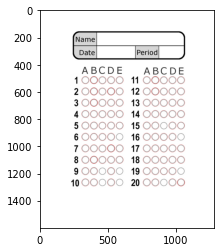

In [3]:
image=io.imread("bubbles_empty.JPEG")
img_canny=canny(rgb2gray(image),3)
show_images([image,img_canny],["img","canny"])

hough_radii = np.arange(25, 30, 1)
hough_res = hough_circle(img_canny, hough_radii)
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,total_num_peaks=100)

print("x centers",cx)
print("y centers",cy)
print("radii",radii)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

#(houghSpace,angles, distances) = hough_line_peaks(hspace=houghSpace1,angles = angles1, dists= distances1,threshold=int(0.5*np.max(houghSpace1)))

In [3]:
def loadImage(path):
    image = io.imread(path)
    if len(image.shape) > 2:
        image = (rgb2gray(image)*255).astype('uint8')
    else:
        image = (image).astype('uint8')
    return image

In [4]:
def Hough(image):
    img = canny(image)
    (M,N) = img.shape
    R_max = 30 #np.max((M,N))
    R_min = 20
    threshold = 10
    region = 10
    R = R_max - R_min
    #Initializing accumulator array.
    #Accumulator array is a 3 dimensional array with the dimensions representing
    #the radius, X coordinate and Y coordinate resectively.
    #Also appending a padding of 2 times R_max to overcome the problems of overflow
    A = np.zeros((R_max,M+2*R_max,N+2*R_max))
    B = np.zeros((R_max,M+2*R_max,N+2*R_max))
    #Precomputing all angles to increase the speed of the algorithm
    theta = np.arange(0,360)*np.pi/180
    edges = np.argwhere(img[:,:]) #Extracting all edge coordinates
    for val in range(R):
        r = R_min+val
        #Creating a Circle Blueprint
        bprint = np.zeros((2*(r+1) - 1,2*(r+1) - 1))
        (m,n) = (r,r) #Finding out the center of the blueprint
        for angle in theta:
            x = int(np.round(r*np.cos(angle)))
            y = int(np.round(r*np.sin(angle)))
            bprint[m+x,n+y] = 1
        constant = np.argwhere(bprint).shape[0]
        for x,y in edges: #For each edge coordinates
            #Centering the blueprint circle over the edges
            #and updating the accumulator array
            X = [x-m-1+R_max,x+m+R_max] #Computing the extreme X values
            Y = [y-n-1+R_max,y+n+R_max] #Computing the extreme Y values
            A[r,X[0]:X[1],Y[0]:Y[1]] += bprint
        A[r][A[r]<threshold*constant/r] = 0
    for r,x,y in np.argwhere(A):
        temp = A[r-region:r+region,x-region:x+region,y-region:y+region]
        try:
            p,a,b = np.unravel_index(np.argmax(temp),temp.shape)
        except:
            continue
        B[r+(p-region),x+(a-region),y+(b-region)] = 1
    circles = B[:,R_max:-R_max,R_max:-R_max] #removing padding
    return circles

In [5]:
def show_Hough(image,circles):
    fig = plt.figure()
    fig, ax = plt.subplots()
    plt.imshow(image)
    circleCoordinates = np.argwhere(circles) #Extracting the circle information
    circle = []
    for r,x,y in circleCoordinates:
        circle.append(plt.Circle((y,x),r,color=(1,0,0),fill=False,linewidth=1))
        ax.add_patch(circle[-1])
    plt.show()
    print(len(circle))
    return circleCoordinates

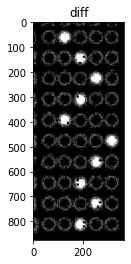

In [6]:
answers= loadImage('Answered.jpeg')
ref= loadImage('ref.jpeg')
diff = ref - answers
thresh = threshold_otsu(diff)
diff=diff > thresh
answers_closing = closing(diff,np.ones((3,3),dtype=int))

show_images([diff],["diff"])

In [7]:

def crop_answers_section(bubbles_w_cross):
    cross_template = loadImage("bubble_w_cross.png")

    result=cv2.matchTemplate(bubbles_w_cross, cross_template, cv2.TM_CCORR_NORMED) 
    objects_matched = []   # get the highest 2 matches with templates and their locations (maxLoc)
    while len(objects_matched) < 2:         # 2 matches

        minV, maxV, minLoc, maxLoc = cv2.minMaxLoc(result)   

        #print(result[maxLoc[1]-3:maxLoc[1]+3,maxLoc[0]-3:maxLoc[0]+3]) 
        print(maxLoc)

        for i in range(-3, 3):          # we remove the highest match to avoid re-matching again
            for j in range(-3, 3):  
                result[maxLoc[1] + i, maxLoc[0] + j] = 0
        
        # print(result[maxLoc[1]-3:maxLoc[1]+3,maxLoc[0]-3:maxLoc[0]+3])

        #get the centers of the highest match template
        maxLoc = list(maxLoc)  #tuple is immutable , convert to list
        maxLoc[0] = maxLoc[0] + cross_template.shape[1] // 2  
        maxLoc[1] = maxLoc[1] + cross_template.shape[0] // 2
        maxLoc = tuple(maxLoc)

        #add location of the match in objects matched
        objects_matched.append(maxLoc)

        objects_matched = sorted(objects_matched) 

    p1 = objects_matched[0]
    p2 = objects_matched[-1]
    bubbles_w_cross = bubbles_w_cross[p1[1]:p2[1], p1[0]:p2[0]]
    return bubbles_w_cross

# cross_template = loadImage("bubble_w_cross.png")
# bubbles_w_cross=loadImage("bubbles_empty_with_cross.jpeg")
# out = crop_answers_section(bubbles_w_cross)
# show_images([bubbles_w_cross,out])



In [8]:
def count_white(r,x,y,diff):
    top_l = (x-r//2,y-r//2)
    bottom_r = (x+r//2,y+r//2)
    count_white=0
    for ix in range(top_l[0],bottom_r[0]):
        for jy in range(top_l[1],bottom_r[1]):
            if diff[ix,jy]==1:
                count_white+=1
    return count_white

In [130]:

def loadModelAnswer(fileName):
    modelAnwser = []
    # open file with fileName and read the data:
    with open(fileName) as file:
        lines = file.readlines()
        for line in lines:
            data = line.rstrip()
            if data == "A" or data == "a" or data == "1":
                modelAnwser.append(1)
            elif data == "B" or data == "b" or data == "2":
                modelAnwser.append(2)
            elif data == "C" or data == "c" or data == "3":
                modelAnwser.append(3)
            elif data == "D" or data == "d" or data == "4":
                modelAnwser.append(4)
            elif data == "E" or data == "e" or data == "5":
                modelAnwser.append(5)
            elif data == "F" or data == "f" or data == "6":
                modelAnwser.append(6)
    
    return modelAnwser

In [105]:
def getAnswers(circleCoordinates,diff):
    # thresh = threshold_otsu(diff)
    # diff=diff > thresh
    #answers_closing = closing(diff,np.ones((3,3),dtype=int))
    #show_images([diff],["diff"])
    radii= circleCoordinates[:,0]
    radius=np.average(radii)
    #print(radius)
    ###
    #sort with x
    circleCoordinates[:,1] = np.sort(circleCoordinates[:,1])
    #print(circleCoordinates)
    # then categorize every answers with the same (near) x value ; diff between each x value is less than radius
    rows = []
    for r,x,y in circleCoordinates:
        if len(rows)==0:
            rows.append([(r,x,y)]) 
        elif np.abs(rows[-1][0][1] - x) < radius:
            rows[-1].append((r,x,y))
        else:
            rows.append([(r,x,y)]) 
    rows = np.array(rows)
    # sort by Y and see if any centers are repeated due to Hough errors!!
    ###
    needsModificationDueYindex = np.zeros(rows.shape[0],dtype=int)
    gotGoodY = False
    goodYindecies = []
    for i in range(rows.shape[0]):
        # sort each row with y
        rows[i,:,2] = np.sort(rows[i,:,2])
        #print("row =",rows[i,:,2]) 
        prevYindex = 0
        for yindex in range(1,len(rows[i,:,2])):
            if np.abs(rows[i,:,2][prevYindex] - rows[i,:,2][yindex]) < radius:
                needsModificationDueYindex[i] = 1
                #print('This row '+ str(i)+' needs modification!!')
                break
            prevYindex = yindex
        if needsModificationDueYindex[i] == 0 and not gotGoodY:
            goodYindecies = rows[i,:,2]
            #print(goodYindecies)
            gotGoodY = True
    #print(needsModificationDueYindex)
    for i in range(len(needsModificationDueYindex)):
        if needsModificationDueYindex[i] == 1:
            rows[i,:,2] = goodYindecies
    #print(rows)
    ###
    # calculate answers and compare it with model answer:
    currentAnswer = np.zeros(rows.shape[0],dtype=int)
    perim_circ= np.pi * radius * 2          
    for rindex in range(rows.shape[0]):
        ansNo = 1
        for r,x,y in rows[rindex]:
            white_count = count_white(r,x,y,diff)
            #print(white_count,x,y)
            if white_count > perim_circ:
                if currentAnswer[rindex] == 0:
                    currentAnswer[rindex] = ansNo
                else:
                    currentAnswer[rindex] = -1
            ansNo += 1
        #print('Next row')
    #print(currentAnswer)
    return currentAnswer

(245, 427)
(1076, 1303)


<Figure size 432x288 with 0 Axes>

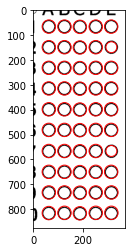

50


<Figure size 432x288 with 0 Axes>

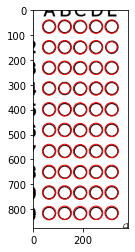

50
(50, 3)
(50, 3)


In [65]:
#initial pipeline

#load reference image and crop/segment
cross_template = loadImage("bubble_w_cross.png")
bubbles_w_cross=loadImage("bubbles_empty_with_cross.jpeg")
out_ref = crop_answers_section(bubbles_w_cross)

ref_chunck1 =out_ref[:,0:370]  #seg bel 7ob
ref_chunck2 =out_ref[:,450:]
thresh1 = threshold_otsu(ref_chunck1)
thresh2 = threshold_otsu(ref_chunck2)
ref_chunck1 = ref_chunck1 > thresh1
ref_chunck2 = ref_chunck2 > thresh2
#show_images([ref_chunck1,ref_chunck2])

circles_chunck1 = Hough(ref_chunck1) 
circles_chunck2 = Hough(ref_chunck2)       

coordinates_chunk1 = show_Hough(ref_chunck1,circles_chunck1)
coordinates_chunk2 = show_Hough(ref_chunck2,circles_chunck2)


print(coordinates_chunk1.shape)
print(coordinates_chunk2.shape)



(245, 427)
(1076, 1303)


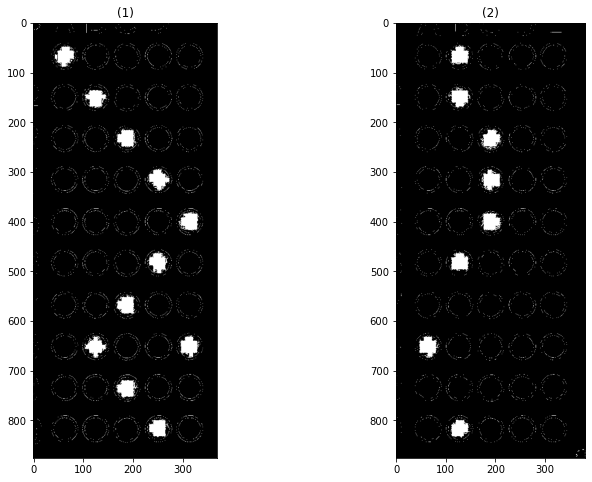

In [66]:
##
# for the answer image:
##

# load it and correct its perspective:
answers = loadImage("ans16.jpeg")
#answers = perspective_correction(answers)
#show_images([answers])
out_ans = crop_answers_section(answers)
out_ans = resize(out_ans, out_ref.shape)
#show_images([out_ans])

ans_chunck1 =out_ans[:,0:370]  #seg bel 7ob
ans_chunck2 =out_ans[:,450:]
thresh1 = threshold_otsu(ans_chunck1)
thresh2 = threshold_otsu(ans_chunck2)
ans_chunck1 = ans_chunck1 > thresh1
ans_chunck2 = ans_chunck2 > thresh2

diff1 = ref_chunck1 ^ ans_chunck1
diff2 = ref_chunck2 ^ ans_chunck2
show_images([diff1,diff2])


In [141]:
modelAnwsers = loadModelAnswer('Model_answer.txt')

chunkAnswers1 = getAnswers(coordinates_chunk1,diff1)
chunkAnswers2 = getAnswers(coordinates_chunk2,diff2)

modelAnwsers = np.array(modelAnwsers)
currAnswers = np.concatenate((chunkAnswers1, chunkAnswers2))

print('Model answers: ',modelAnwsers)
print('Current answers: ',currAnswers)
grade = (modelAnwsers == currAnswers)

print('Grade: ' + str(grade.sum()) + '/' + str(len(grade)))


Model answers:  [1 2 3 4 5 4 3 2 3 4 2 2 3 3 3 2 2 1 1 4]
Current answers:  [ 1  2  3  4  5  4  3 -1  3  4  2  2  3  3  3  2  0  1  0  2]
Grade: 16/20
